# Transfer learning for Few-shot Classification from the Algorithm's Perspective

Original content (this Jupyter notebook) created by Matthew McAteer([`@MatthewMcAteer0`]())

Dataset and original prompt supplied by Vinay Prabhu ([`@vinayprabhu`](https://twitter.com/vinayprabhu)) and the UnifyID Team ([`@UnifyID`](https://twitter.com/UnifyID)).

------------------------------------
# Part 1 of 3: Preparing the Data #
------------------------------------

**Since the Ginger_Tri Dataset is already available on Github, Part 1 is entirely optional. If you are modifying the dataset, or are curious, feel free to go through the [Dataset_Preparation.ipynb](Dataset_Preparation.ipynb) notebook. Otherwise you can skip ahead to Part 2 of 2 for the model-building**

**Steps 1, 2, and 3 of the experimental workflow are covered in the preparation notebook**

------------------------------------
# Part 2 of 3: Training the Model #
------------------------------------

We now have the file directory for the training and test datasets, both of which have been constructed from a sample of just 21 high resolution images. We now have 3,000 $256 \times 256$ images, divided up among Test and Training datasets.

In part 2, we will focus on the model training itself, along with the visualization of what the model is interpreting in the images it's fed. 

**Note: If you have a GPU, make sure it is enabled at this point. This could mean the difference between training taking 25 minutes with a GPU or 5 hours without.**

If you are running this in Google Colab, go to Runtime > Change Runtime Type, and under "Hardware Accelerator" in "Notebook Settings" select *GPU* instead of *None*.

## Step 4: Transfer learn and estimate the error metrics

Now that we have the image dataset, we can move onto the transfer learning. Transfer learning is based on the assumption that tuning a network to weights of one dataset will have benefits in either training time or accuracy for new training tasks. 

Successful transfer learning has going for it the fact that the ImageNet database has a ver more expansive set of objects and scenes to classify. This should theoretically serve as a robust feature detection component for a network that is fine-tuned to a much smaller and relatively simpler dataset.  

**Our fine-tuning will make use of the `ginger_tri_256x256.zip` images. These contain the 256x256 pixel versions of the training and test jpegs.**

In [1]:
!wget -O ginger_tri_256x256.zip https://github.com/matthew-mcateer/Ginger_tri/raw/master/ginger_tri_256x256.zip

--2019-03-03 18:37:14--  https://github.com/matthew-mcateer/Ginger_tri/raw/master/ginger_tri_256x256.zip
Resolving github.com (github.com)... 140.82.118.3, 140.82.118.4
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/matthew-mcateer/Ginger_tri/master/ginger_tri_256x256.zip [following]
--2019-03-03 18:37:19--  https://raw.githubusercontent.com/matthew-mcateer/Ginger_tri/master/ginger_tri_256x256.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22567806 (22M) [application/zip]
Saving to: ‘ginger_tri_256x256.zip’

ginger_tri_256x256. 100%[===================>]  21.52M  --.-KB/s    in 0.1s    

2019-03-03 18:37:20 (173 MB/s) - ‘ginger_tri_256x256.zip

In [2]:
!ls

ginger_tri_256x256.zip	sample_data


In [3]:
!unzip ginger_tri_256x256.zip

Archive:  ginger_tri_256x256.zip
   creating: test/
   creating: test/galangal/
  inflating: test/galangal/750.jpg   
  inflating: test/galangal/751.jpg   
  inflating: test/galangal/752.jpg   
  inflating: test/galangal/753.jpg   
  inflating: test/galangal/754.jpg   
  inflating: test/galangal/755.jpg   
  inflating: test/galangal/756.jpg   
  inflating: test/galangal/757.jpg   
  inflating: test/galangal/758.jpg   
  inflating: test/galangal/759.jpg   
  inflating: test/galangal/760.jpg   
  inflating: test/galangal/761.jpg   
  inflating: test/galangal/762.jpg   
  inflating: test/galangal/763.jpg   
  inflating: test/galangal/764.jpg   
  inflating: test/galangal/765.jpg   
  inflating: test/galangal/766.jpg   
  inflating: test/galangal/767.jpg   
  inflating: test/galangal/768.jpg   
  inflating: test/galangal/769.jpg   
  inflating: test/galangal/770.jpg   
  inflating: test/galangal/771.jpg   
  inflating: test/galangal/772.jpg   
  inflating: test/galangal/773.jpg   
  inflat

In [0]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from shutil import copy, copytree, rmtree
import cv2

In [5]:
print("Tensorflow version {}".format(tf.__version__))
print("GPU Device Name {}:".format(tf.test.gpu_device_name()))

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

Tensorflow version 1.13.1
GPU Device Name /device:GPU:0:


In [6]:
!ls

ginger_tri_256x256.zip	sample_data  test  train


### Fine tuning NASNetMobile Pretrained model using Ginger-Tri dataset

Fortunately for our purposes of Transfer Learning, Keras and other Deep Learning libraries provide pretrained models. These are deep neural networks with efficient architectures(like VGG,Inception,ResNet) that are already trained on datasets like ImageNet. This allows us to create a model that converges much more quickly compared to models trained de novo. We currently have a subset of dataset with 3 classes - galangal, ginger, and turmeric. We will define and train our model below.

In [8]:
%%time

K.clear_session()
n_classes = 3
img_width, img_height = 224, 224
train_data_dir = 'train'
validation_data_dir = 'test'
nb_train_samples = 2250
nb_validation_samples = 750
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

nasnetmobile = NASNetMobile(weights='imagenet', include_top=False)
x = nasnetmobile.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3, 
                    kernel_regularizer=regularizers.l2(0.005), 
                    activation='softmax')(x)
model = Model(inputs=nasnetmobile.input, 
              outputs=predictions)

model.compile(optimizer=SGD(lr=0.0001, 
                            momentum=0.9), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class_NASNetMobile.hdf5', 
                               verbose=1, 
                               save_best_only=True)
csv_logger = CSVLogger('history_3class_NASNetMobile.log')
history = model.fit_generator(train_generator,
                              steps_per_epoch = nb_train_samples//batch_size,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size,
                              epochs=30,
                              verbose=1,
                              callbacks=[csv_logger, checkpointer])
model.save('model_trained_3class_NASNetMobile.hdf5')

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
Epoch 1/30
47/47 [==============================] - 11s 225ms/step - loss: 1.0259 - acc: 0.4667

Epoch 00001: val_loss improved from inf to 1.02595, saving model to best_model_3class_NASNetMobile.hdf5
141/141 [==============================] - 341s 2s/step - loss: 1.1055 - acc: 0.4271 - val_loss: 1.0259 - val_acc: 0.4667
Epoch 2/30
47/47 [==============================] - 6s 138ms/step - loss: 0.9530 - acc: 0.5200

Epoch 00002: val_loss improved from 1.02595 to 0.95301, saving model to best_model_3class_NASNetMobile.hdf5
141/141 [==============================] - 77s 544ms/step - loss: 0.9319 - acc: 0.5804 - val_loss: 0.9530 - val_acc: 0.5200
Epoch 3/30
47/47 [==============================] - 7s 139ms/step - loss: 0.8604 - acc: 0.6120

Epoch 00003: val_loss improved from 0.95301 to 0.86044, saving model to best_model_3class_NASNetMobile.hdf5
141/141 [==============================] - 76s 540ms/step - lo

In [9]:
class_map_3 = train_generator.class_indices
class_map_3

{'galangal': 0, 'ginger': 1, 'turmeric': 2}

### Accuracy & Loss Results

In [0]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
#This sets the resolution of the plot outputs
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()

def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

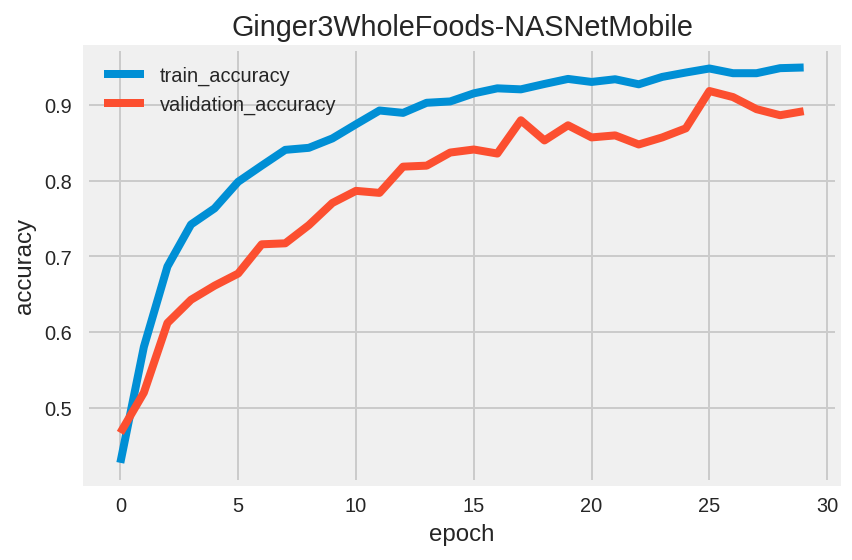

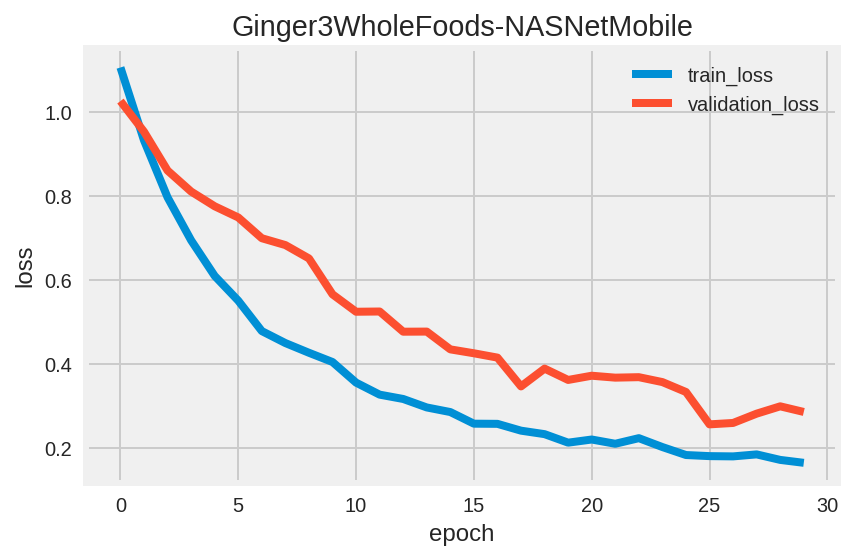

In [11]:
plot_accuracy(history,'Ginger3WholeFoods-NASNetMobile')
plot_loss(history,'Ginger3WholeFoods-NASNetMobile')

In [12]:
!ls

best_model_3class_NASNetMobile.hdf5	sample_data
ginger_tri_256x256.zip			test
history_3class_NASNetMobile.log		train
model_trained_3class_NASNetMobile.hdf5


When fine-tuning an NASNetMobile model, even on few classes the accuracy consistently increases with respect to epochs, with the loss following the inverse pattern. For many epochs, accuracy on the validation set is higher than on the training dataset. There are many reasons that could be attributed to this. In addition to the weights for ImageNet being one of the more commonly used sources of Transfer learning weights [[2]](#scrollTo=ek-3esN_z32w), our final layers also makes use of Dropout for higher validation accuracy [[3]](#scrollTo=ek-3esN_z32w).

In [13]:
%%time

# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('best_model_3class_NASNetMobile.hdf5', compile = False)

CPU times: user 30.1 s, sys: 491 ms, total: 30.6 s
Wall time: 30.5 s


In [0]:
food_list = ['galangal', 'ginger', 'turmeric']

def predict_class(model, images, show = True):
    for img in images:
        img = image.load_img(img, target_size=(224, 224))
        img = image.img_to_array(img)                    
        img = np.expand_dims(img, axis=0)         
        img /= 255.                                      

        pred = model.predict(img)
        index = np.argmax(pred)
        food_list.sort()
        pred_value = food_list[index]
        if show:
            plt.imshow(img[0])                           
            plt.axis('off')
            plt.title(pred_value)
            plt.show()

In [19]:
# Downloading images from internet using the URLs
!wget -O galangal.jpg https://github.com/matthew-mcateer/Ginger_tri/raw/master/edge_case_images/galangal_900.jpg
!wget -O ginger.jpg https://github.com/matthew-mcateer/Ginger_tri/raw/master/edge_case_images/ginger_889.jpg
!wget -O turmeric.jpg https://github.com/matthew-mcateer/Ginger_tri/raw/master/edge_case_images/turmeric_790.jpg

# If you have an image in your local computer and want to try it, uncomment the below code to upload the image files

# from google.colab import files
# image = files.upload()

--2019-03-03 20:07:44--  https://github.com/matthew-mcateer/Ginger_tri/raw/master/edge_case_images/galangal_900.jpg
Resolving github.com (github.com)... 140.82.118.4, 140.82.118.3
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/matthew-mcateer/Ginger_tri/master/edge_case_images/galangal_900.jpg [following]
--2019-03-03 20:07:44--  https://raw.githubusercontent.com/matthew-mcateer/Ginger_tri/master/edge_case_images/galangal_900.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7249 (7.1K) [image/jpeg]
Saving to: ‘galangal.jpg’

galangal.jpg        100%[===================>]   7.08K  --.-KB/s    in 0s      

2019-03-03 20:07:44 (110 MB/s) - ‘galanga

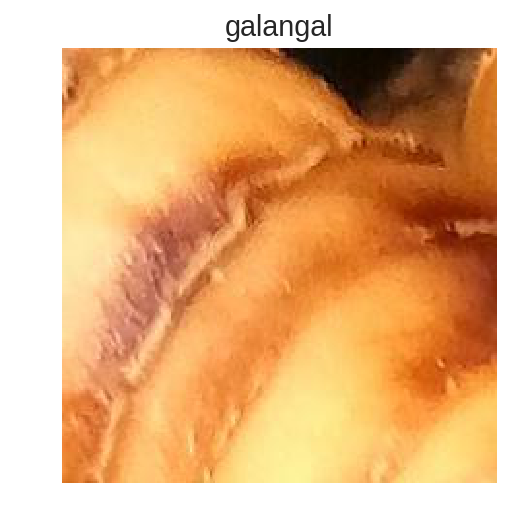

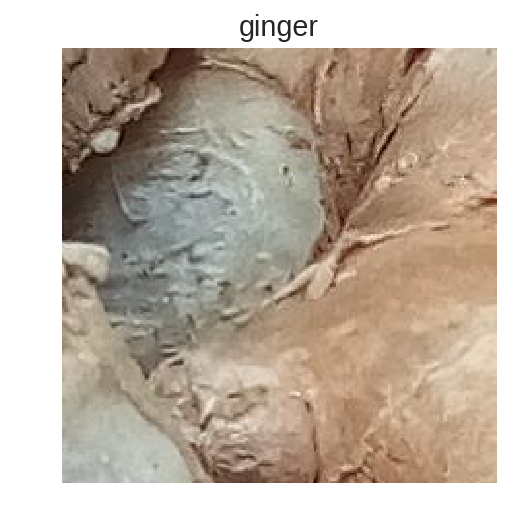

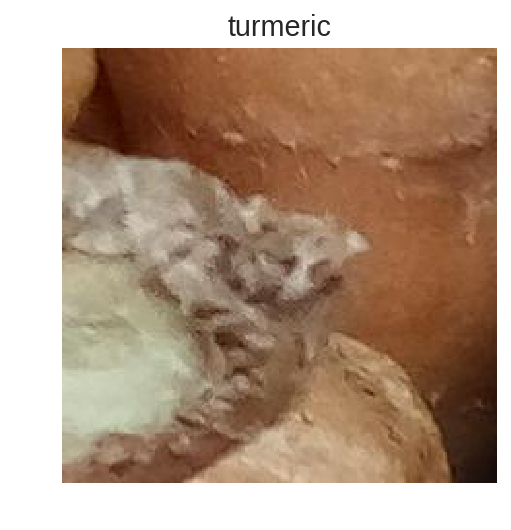

In [22]:
# Make a list of downloaded images and test the trained model
images = []
images.append('galangal.jpg')
images.append('ginger.jpg')
images.append('turmeric.jpg')
predict_class(model_best, images, True)

It appears that our network has made the correct predictions, though the trainind and validation loss are both still less than that of the InceptionV3.

------------------------------------
# Part 3 of 3: Analyzing the Model #
------------------------------------
**See the analysis notebooks for further details on this**